> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [TMDb movie data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [1]:
# <a id='intro'></a>
## Investigate Data set to get and show the insights and relation between 

### This data set is about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

### Question-01: what is the most common Genres produced in the market
### Question-02: Which genres are most popular
### Question-03: what is the most common Genres produced in the market

SyntaxError: invalid syntax (<ipython-input-1-a24272088fd6>, line 6)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


In [3]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

    100% |████████████████████████████████| 10.5MB 1.7MB/s eta 0:00:01  3% |█▏                              | 368kB 12.8MB/s eta 0:00:01    9% |███                             | 1.0MB 12.8MB/s eta 0:00:01    15% |█████                           | 1.6MB 29.6MB/s eta 0:00:01    21% |██████▉                         | 2.2MB 18.9MB/s eta 0:00:01    51% |████████████████▌               | 5.4MB 15.1MB/s eta 0:00:01    63% |████████████████████▍           | 6.6MB 12.7MB/s eta 0:00:01    69% |██████████████████████▎         | 7.3MB 13.0MB/s eta 0:00:01    82% |██████████████████████████▎     | 8.6MB 11.3MB/s eta 0:00:01    87% |████████████████████████████▏   | 9.2MB 9.3MB/s eta 0:00:01    94% |██████████████████████████████▍ | 9.9MB 17.5MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 1.4MB/s eta 0:00:01  4% |█▌                              | 624kB 12.1MB/s eta 0:00:02    8% |██▉                             | 1.2MB 11.8MB/s eta 0:00:02    13% |████▎                          

In [ ]:
<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Replace this header name!)

# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


In [ ]:
### Data loading to be inspected

In [2]:
df = pd.read_csv("tmdb-movies.csv")
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [ ]:
### Data Exploration and see find out the headlines in 

In [3]:
df.shape

(10866, 21)

In [4]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [ ]:
### Data Wrangling after finsished inspection
## droping the unnecessary columns like id, home page, tagline, etc....

In [6]:
df.drop(['id', 'imdb_id','tagline' , 'homepage', 'tagline', 'overview' , 'budget', 'revenue'], axis=1, inplace=True)

In [7]:
df.head()

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,based on novel|revolution|dystopia|sequel|dyst...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,android|spaceship|jedi|space opera|3d,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,car race|speed|revenge|suspense|car,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [8]:
df.describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,0.646441,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,1.000185,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,0.000065,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,0.207583,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,0.383856,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,0.713817,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,32.985763,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 14 columns):
popularity              10866 non-null float64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
keywords                9373 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(3), object(7)
memory usage: 1.2+ MB


In [ ]:
## converting types into the correct types

In [10]:
df.popularity = df.popularity.astype(int)
df['release_date']= pd.to_datetime(df['release_date'])
df.vote_average = df.vote_average.astype(int)
df['release_year']= pd.to_datetime(df['release_year'])
df.budget_adj = df.budget_adj .astype(int)
df.revenue_adj = df.revenue_adj.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 14 columns):
popularity              10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
keywords                9373 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null datetime64[ns]
vote_count              10866 non-null int64
vote_average            10866 non-null int64
release_year            10866 non-null datetime64[ns]
budget_adj              10866 non-null int64
revenue_adj             10866 non-null int64
dtypes: datetime64[ns](2), int64(6), object(6)
memory usage: 1.2+ MB


In [ ]:
## making histogram to see some insights 

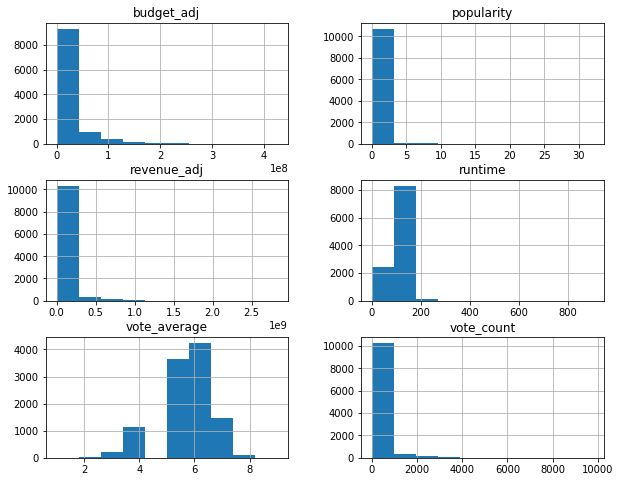

In [11]:
df.hist(figsize=(10,8));

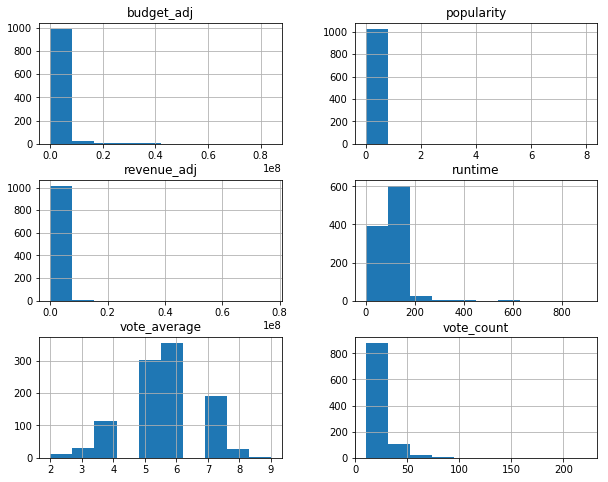

In [12]:
df[df.production_companies.isnull()].hist(figsize=(10,8));

In [ ]:
## removing the null values to correct data

In [13]:
df['cast'] = df['cast'].fillna('no entry')
df['director'] = df['director'].fillna('no entry')
df['keywords'] = df['keywords'].fillna('no entry')
df['genres'] = df['genres'].fillna('no entry')
df['production_companies'] = df['production_companies'].fillna('no entry')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 14 columns):
popularity              10866 non-null int64
original_title          10866 non-null object
cast                    10866 non-null object
director                10866 non-null object
keywords                10866 non-null object
runtime                 10866 non-null int64
genres                  10866 non-null object
production_companies    10866 non-null object
release_date            10866 non-null datetime64[ns]
vote_count              10866 non-null int64
vote_average            10866 non-null int64
release_year            10866 non-null datetime64[ns]
budget_adj              10866 non-null int64
revenue_adj             10866 non-null int64
dtypes: datetime64[ns](2), int64(6), object(6)
memory usage: 1.2+ MB


In [ ]:
### Research Question 2 (what is the most common Genres produced in the market)

In [14]:
df['genres'].describe()

count      10866
unique      2040
top       Comedy
freq         712
Name: genres, dtype: object

In [ ]:
## by Checking Genres produced, the most common Genres produced in the market is Comedy movies

In [ ]:
### Research Question 2 (Which genres are most popular)

In [ ]:
## checking some insights and relations of popularity and genres

In [15]:
df.groupby(['genres' , 'popularity']).max().sort_values('popularity' , ascending=False)

original_title  \
genres                                            popularity                                                      
Action|Adventure|Science Fiction|Thriller         32                                             Jurassic World   
                                                  28                                         Mad Max: Fury Road   
Adventure|Drama|Science Fiction                   24                                               Interstellar   
Action|Science Fiction|Adventure                  14                                    Guardians of the Galaxy   
Adventure|Science Fiction|Thriller                13                                                  Insurgent   
Action|Adventure|Science Fiction                  12                        Captain America: The Winter Soldier   
Adventure|Action|Science Fiction                  12                                                  Star Wars   
Action|Adventure|Science Fiction|Fantasy          11                               Star Wars: The Force Awakens   
Action|Thriller                                   11                                                  John Wick   
Adventure|Fantasy                                 10                  The Hobbit: The Battle of the Five Armies   
Science Fiction|Adventure|Thriller                10                      The Hunger Games: Mockingjay - Part 1   
Action|Adventure|Fantasy|Science Fiction          9                                                      Avatar   
Action|Crime|Thriller                             9                                                   Furious 7   
Action|Thriller|Science Fiction|Mystery|Adventure 9                                                   Inception   
Western|Drama|Adventure|Thriller                  9                                                The Revenant   
Adventure|Fantasy|Family                          8                    Harry Potter and the Philosopher's Stone   
Action|Animation|Horror                           8                                     Underworld: Endless War   
Science Fiction|Action|Thriller|Adventure         8                                          Terminator Genisys   
History|Drama|Thriller|War                        8                                          The Imitation Game   
Adventure|Family|Animation|Action|Comedy          8                                                  Big Hero 6   
Drama                                             8                                                  Fight Club   
Drama|Action|Crime|Thriller                       8                                             The Dark Knight   
Thriller|Crime                                    8                                                Pulp Fiction   
Adventure|Fantasy|Action                          8                       The Lord of the Rings: The Two Towers   
Action|Adventure|Science Fiction                  7                          Captain America: The First Avenger   
Action|Science Fiction                            7                                                  The Matrix   
Family|Animation|Adventure|Comedy                 7                                                     Minions   
Adventure|Fantasy|Action                          7               The Lord of the Rings: The Return of the King   
Action|Mystery|Science Fiction|Thriller           7                                             The Maze Runner   
Science Fiction|Action|Adventure                  7                                                The Avengers   
...                                                                                                         ...   
Comedy|History|Horror                             0                                       Cannibal! The Musical   
Comedy|Horror|Thriller|Mystery|Fantasy            0                                                Bubba Ho-tep   
Comedy|Horror|Thriller|Mystery                    0                     

In [16]:
df.groupby(['genres' , 'popularity']).sum().sort_values('popularity' , ascending=False)

runtime  \
genres                                            popularity            
Action|Adventure|Science Fiction|Thriller         32              124   
                                                  28              120   
Adventure|Drama|Science Fiction                   24              169   
Action|Science Fiction|Adventure                  14              121   
Adventure|Science Fiction|Thriller                13              119   
Action|Adventure|Science Fiction                  12              136   
Adventure|Action|Science Fiction                  12              121   
Action|Adventure|Science Fiction|Fantasy          11              136   
Action|Thriller                                   11              101   
Adventure|Fantasy                                 10              144   
Science Fiction|Adventure|Thriller                10              123   
Action|Adventure|Fantasy|Science Fiction          9               162   
Action|Crime|Thriller                             9               137   
Action|Thriller|Science Fiction|Mystery|Adventure 9               148   
Western|Drama|Adventure|Thriller                  9               156   
Adventure|Fantasy|Family                          8               152   
Action|Animation|Horror                           8                18   
Science Fiction|Action|Thriller|Adventure         8               125   
History|Drama|Thriller|War                        8               113   
Adventure|Family|Animation|Action|Comedy          8               102   
Drama                                             8               139   
Drama|Action|Crime|Thriller                       8               152   
Thriller|Crime                                    8               154   
Adventure|Fantasy|Action                          8               357   
Action|Adventure|Science Fiction                  7               124   
Action|Science Fiction                            7               136   
Family|Animation|Adventure|Comedy                 7                91   
Adventure|Fantasy|Action                          7               201   
Action|Mystery|Science Fiction|Thriller           7               113   
Science Fiction|Action|Adventure                  7               143   
...                                                               ...   
Comedy|History|Horror                             0                97   
Comedy|Horror|Thriller|Mystery|Fantasy            0                92   
Comedy|Horror|Thriller|Mystery                    0                99   
Comedy|Horror|Thriller|Crime                      0               112   
Comedy|Horror|Thriller                            0               626   
Comedy|Horror|Science Fiction                     0               989   
Comedy|Horror|Romance                             0               100   
Comedy|Horror|Mystery|Thriller                    0                95   
Comedy|Horror|Mystery                             0                86   
Comedy|Horror|Music                               0                82   
Comedy|Horror|Fantasy                             0               286   
Comedy|Horror|Action|Science Fiction              0               102   
Comedy|Horror|Action                              0                96   
Comedy|Horror                                     0              5931   
Comedy|History                                    0               161   
Comedy|Fantasy                                    0               947   
Comedy|Foreign|Romance                            0               249   
Comedy|Foreign                                    0               588   
Comedy|Fantasy|Thriller                           0               100   
Comedy|Fantasy|Science Fiction                    0               380   
Comedy|Fantasy|Romance|TV Movie                   0                90   
Comedy|Fantasy|Romance|Science Fiction            0               223   
Comedy|Fantasy|Romance                         

In [17]:
df.groupby(['genres' , 'popularity']).describe().sort_values('popularity' , ascending=False)

budget_adj  \
                                                                  count   
genres                                            popularity              
Action|Adventure|Science Fiction|Thriller         32                1.0   
                                                  28                1.0   
Adventure|Drama|Science Fiction                   24                1.0   
Action|Science Fiction|Adventure                  14                1.0   
Adventure|Science Fiction|Thriller                13                1.0   
Action|Adventure|Science Fiction                  12                1.0   
Adventure|Action|Science Fiction                  12                1.0   
Action|Adventure|Science Fiction|Fantasy          11                1.0   
Action|Thriller                                   11                1.0   
Adventure|Fantasy                                 10                1.0   
Science Fiction|Adventure|Thriller                10                1.0   
Action|Adventure|Fantasy|Science Fiction          9                 1.0   
Action|Crime|Thriller                             9                 1.0   
Action|Thriller|Science Fiction|Mystery|Adventure 9                 1.0   
Western|Drama|Adventure|Thriller                  9                 1.0   
Adventure|Fantasy|Family                          8                 1.0   
Action|Animation|Horror                           8                 1.0   
Science Fiction|Action|Thriller|Adventure         8                 1.0   
History|Drama|Thriller|War                        8                 1.0   
Adventure|Family|Animation|Action|Comedy          8                 1.0   
Drama                                             8                 1.0   
Drama|Action|Crime|Thriller                       8                 1.0   
Thriller|Crime                                    8                 1.0   
Adventure|Fantasy|Action                          8                 2.0   
Action|Adventure|Science Fiction                  7                 1.0   
Action|Science Fiction                            7                 1.0   
Family|Animation|Adventure|Comedy                 7                 1.0   
Adventure|Fantasy|Action                          7                 1.0   
Action|Mystery|Science Fiction|Thriller           7                 1.0   
Science Fiction|Action|Adventure                  7                 1.0   
...                                                                 ...   
Comedy|History|Horror                             0                 1.0   
Comedy|Horror|Thriller|Mystery|Fantasy            0                 1.0   
Comedy|Horror|Thriller|Mystery                    0                 1.0   
Comedy|Horror|Thriller|Crime                      0                 1.0   
Comedy|Horror|Thriller                            0                 7.0   
Comedy|Horror|Science Fiction                     0                11.0   
Comedy|Horror|Romance                             0                 1.0   
Comedy|Horror|Mystery|Thriller                    0                 1.0   
Comedy|Horror|Mystery                             0                 1.0   
Comedy|Horror|Music                               0                 1.0   
Comedy|Horror|Fantasy                             0                 3.0   
Comedy|Horror|Action|Science Fiction              0                 1.0   
Comedy|Horror|Action                              0                 1.0   
Comedy|Horror                                     0                67.0   
Comedy|History                                    0                 3.0   
Comedy|Fantasy                                    0                10.0   
Comedy|Foreign|Romance                            0                 2.0   
Comedy|Foreign                                    0                 6.0   
Comedy|Fantasy|Thriller                           0                 1.0   
Comedy|Fantasy|Science Fiction                    0                 4.0   
Comedy|Fant

In [18]:
df.groupby('genres').popularity.mean()

genres
Action                                                 0.222222
Action|Adventure                                       0.266667
Action|Adventure|Animation                             0.000000
Action|Adventure|Animation|Comedy|Drama                0.000000
Action|Adventure|Animation|Comedy|Family               0.000000
Action|Adventure|Animation|Drama|Family                0.000000
Action|Adventure|Animation|Family                      0.000000
Action|Adventure|Animation|Family|Fantasy              0.333333
Action|Adventure|Animation|Family|Mystery              0.000000
Action|Adventure|Animation|Family|Science Fiction      0.750000
Action|Adventure|Animation|Fantasy                     0.000000
Action|Adventure|Animation|Fantasy|Horror              0.000000
Action|Adventure|Animation|Fantasy|Science Fiction     0.000000
Action|Adventure|Animation|Science Fiction             0.000000
Action|Adventure|Animation|Science Fiction|Crime       0.000000
Action|Adventure|Animation|Scienc

In [19]:
df.groupby('genres').popularity.max()

genres
Action                                                 4
Action|Adventure                                       2
Action|Adventure|Animation                             0
Action|Adventure|Animation|Comedy|Drama                0
Action|Adventure|Animation|Comedy|Family               0
Action|Adventure|Animation|Drama|Family                0
Action|Adventure|Animation|Family                      0
Action|Adventure|Animation|Family|Fantasy              1
Action|Adventure|Animation|Family|Mystery              0
Action|Adventure|Animation|Family|Science Fiction      3
Action|Adventure|Animation|Fantasy                     0
Action|Adventure|Animation|Fantasy|Horror              0
Action|Adventure|Animation|Fantasy|Science Fiction     0
Action|Adventure|Animation|Science Fiction             0
Action|Adventure|Animation|Science Fiction|Crime       0
Action|Adventure|Animation|Science Fiction|Thriller    2
Action|Adventure|Comedy                                1
Action|Adventure|Comedy|

In [ ]:
## by cheking the above insights, we find that Action, Adventure ,Animation always are the top rated movies

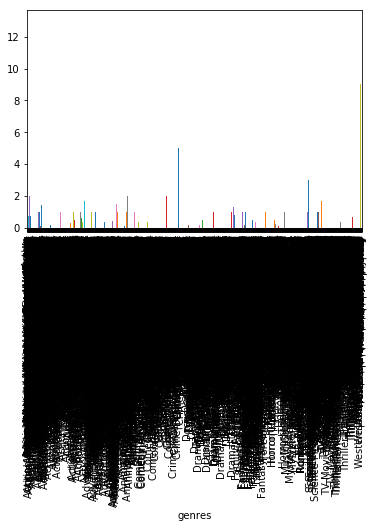

In [20]:
df.groupby('genres').popularity.mean().plot(kind= 'bar');

In [ ]:
## Answer of Q2 (action movies takes the highest rate and popularity)

In [21]:
### Research Question 3  (What kinds of properties are associated with movies that have high revenues?)

In [ ]:
## First revenue_Adj & Budget_adj to be div by 1000000 to get number in milions 

In [34]:
df['revenue_adj'] = df['revenue_adj'].div(1000000)


In [30]:
df['budget_adj']= df['budget_adj'].div(1000000)

In [ ]:
## making histogram to see some insights 

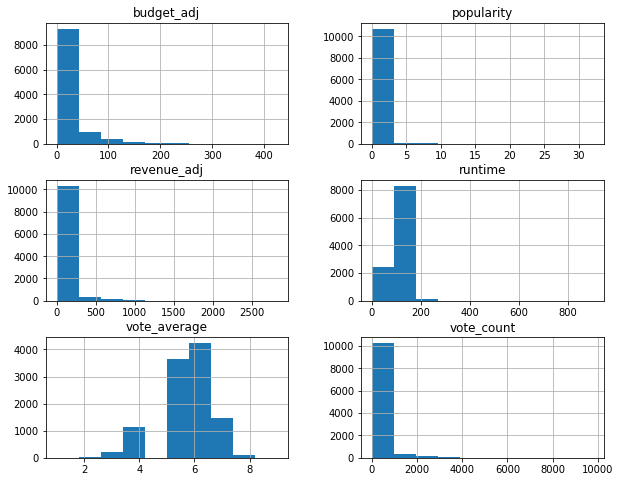

In [35]:
df.hist(figsize=(10,8));

In [ ]:
## by observation, We can note that there is a relation between revenue and budget, popularity and voting count

In [ ]:
## checking relations by histograms for every insight

In [ ]:
## checking relation between revenue and budget

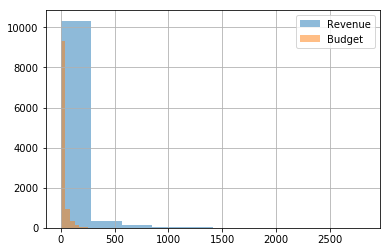

In [36]:
df['revenue_adj'].hist( alpha=0.5, bins=10, label='Revenue')
df['budget_adj'].hist( alpha=0.5, bins=10, label='Budget')
plt.legend();

In [ ]:
# We can note that when budget increased, revenue increase 

In [ ]:
## checking relation between revenue and popularity

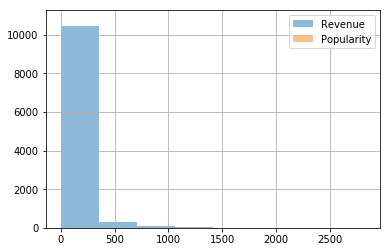

In [44]:
df['revenue_adj'].hist( alpha=0.5, bins=8, label='Revenue')
df['popularity'].hist( alpha=0.5, bins=8, label='Popularity')
plt.legend();

In [ ]:
# We can note that when popularity increased, revenue increase 

In [ ]:
## checking relation between revenue and Voting count

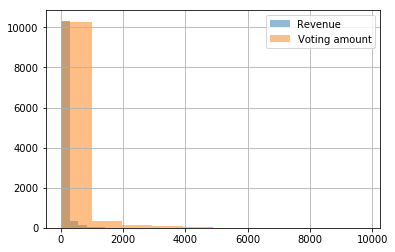

In [43]:
df['revenue_adj'].hist( alpha=.5, bins=10, label='Revenue')
df['vote_count'].hist( alpha=0.5, bins=10, label='Voting amount')
plt.legend();

In [ ]:
# We can note that people talk much and vote alote for the movies which get more revenues

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0